In [312]:
!pip install pytorch_lightning
!pip install torchmetrics

In [313]:
import ast
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, RandomSampler
from torchmetrics.classification.accuracy import Accuracy

from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

# Data processing

In [314]:
with open('yc_essential_data.json', 'r') as file:
    data_json = json.load(file)

In [315]:
data_pd = pd.read_csv('yc_essential_data.csv')

In [316]:
data_pd.head()

,id,name,slug,former_names,small_logo_thumb_url,website,all_locations,long_description,one_liner,team_size,...,batch,status,industries,regions,stage,app_video_public,demo_day_video_public,app_answers,question_answers,objectID
0,370,Wufoo,wufoo,[],https://bookface-images.s3.amazonaws.com/small...,http://wufoo.com,"Tampa, FL, USA",Wufoo is a web application that helps anybody ...,Online form builder.,11.0,...,W06,Acquired,"[""B2B"", ""Marketing""]","[""United States of America"", ""America / Canada""]",Early,False,False,NaN,False,370
1,369,Project Wedding,project-wedding,[],/company/thumb/missing.png,http://projectwedding.com,"Bethesda, MD, USA","Finding wedding vendors is hard. In 2007, a co...",NaN,2.0,...,W06,Acquired,"[""Consumer"", ""Home and Personal""]","[""United States of America"", ""America / Canada""]",Early,False,False,NaN,False,369
2,367,Clustrix,clustrix,[],https://bookface-images.s3.amazonaws.com/small...,http://clustrix.com,"San Francisco, CA, USA",Clustrix provides the leading scale-out relati...,NaN,51.0,...,W06,Acquired,"[""B2B"", ""Infrastructure""]","[""United States of America"", ""America / Canada""]",Growth,False,False,NaN,False,367
3,366,Inkling,inkling,[],/company/thumb/missing.png,http://inklingmarkets.com,"Chicago, IL, USA","Inkling, based in Chicago, Illinois, offers co...",NaN,11.0,...,W06,Acquired,"[""B2B"", ""Finance and Accounting""]","[""United States of America"", ""America / Canada""]",Early,False,False,NaN,False,366
4,372,Audiobeta,audiobeta,[],/company/thumb/missing.png,http://audiobeta.com,"Somerville, MA, USA",AudioBeta develops web-based applications that...,NaN,0.0,...,W06,Inactive,"[""B2B"", ""Marketing""]","[""United States of America"", ""America / Canada""]",Early,False,False,NaN,False,372


# Adding remote and simple analysis

In [317]:
def has_remote(info):
    if isinstance(info, str):
        return "remote" in info.lower()
    elif isinstance(info, list):
        for subinfo in info:
            if "remote" in subinfo.lower():
                return True
        return False

In [318]:
data_pd['has_remote'] = (data_pd["all_locations"].apply(has_remote) == True) | (data_pd["regions"].apply(has_remote) == True)

data_pd['has_remote']

0       False
1       False
2       False
3       False
4       False
        ...  
4412    False
4413     True
4414     True
4415     True
4416     True
Name: has_remote, Length: 4417, dtype: bool

In [319]:
print(data_pd['has_remote'].mean())

0.6182929590219606


In [320]:
import numpy as np
from scipy.stats import norm

def bernoulli_confidence_interval(data):
    n = len(data)
    p_hat = np.mean(data)
    z_score = norm.ppf(0.975)  # 1.96 for a 95% confidence interval

    margin_of_error = z_score * np.sqrt((p_hat * (1 - p_hat)) / n)
    lower_bound = p_hat - margin_of_error
    upper_bound = p_hat + margin_of_error

    return lower_bound, upper_bound

# Calculate the 95% confidence interval
lower, upper = bernoulli_confidence_interval(np.array(data_pd['has_remote'].values))

# Display the result
print(f"95% Confidence Interval for remote fraction: ({lower:.4f}, {upper:.4f})")

95% Confidence Interval for remote fraction: (0.6040, 0.6326)


# Analysis of the remote from the batch

In [321]:
data_pd_remote_size_batch = data_pd[['has_remote', 'team_size', 'batch']]
data_pd_remote_size_batch.head()

,has_remote,team_size,batch
0,False,11.0,W06
1,False,2.0,W06
2,False,51.0,W06
3,False,11.0,W06
4,False,0.0,W06


In [322]:
data_pd_remote_size_batch['remote_fraction'] = data_pd_remote_size_batch.groupby('batch').has_remote.transform(np.mean)
pd_batch_remote_fraction = data_pd_remote_size_batch[['batch', 'remote_fraction']].drop_duplicates()
dict_batch_remote_fraction = pd_batch_remote_fraction.set_index('batch')['remote_fraction'].to_dict()

if 'Unspecified' in dict_batch_remote_fraction.keys():
    del dict_batch_remote_fraction['Unspecified']
if 'IK12' in dict_batch_remote_fraction.keys():
    del dict_batch_remote_fraction['IK12']

sorted_all_batches = sorted(dict_batch_remote_fraction.items(), key=lambda batch: (ord(batch[0][1]) * 10 + ord(batch[0][2]), -ord(batch[0][0])))

<ipython-input-322-a943554eb47b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd_remote_size_batch['remote_fraction'] = data_pd_remote_size_batch.groupby('batch').has_remote.transform(np.mean)


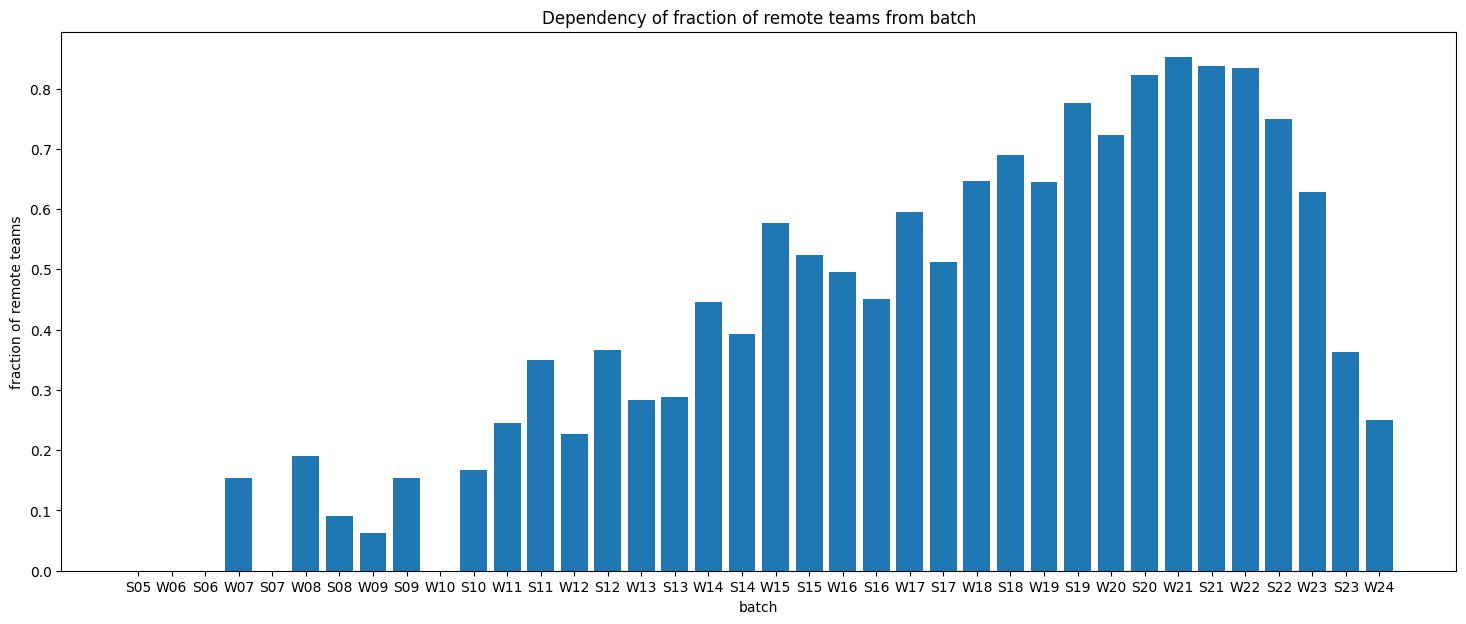

In [323]:
plt.figure(figsize=(18, 7))

plt.bar([batch[0] for batch in sorted_all_batches], [batch[1] for batch in sorted_all_batches])

plt.title('Dependency of fraction of remote teams from batch')
plt.xlabel('batch')
plt.ylabel('fraction of remote teams')


plt.show()

In [324]:
data_pd_remote_size_batch_more_3 = data_pd_remote_size_batch[data_pd_remote_size_batch['team_size'] > 3]
data_pd_remote_size_batch_more_3['remote_fraction'] = data_pd_remote_size_batch_more_3.groupby('batch').has_remote.transform(np.mean)
pd_batch_remote_fraction = data_pd_remote_size_batch_more_3[['batch', 'remote_fraction']].drop_duplicates()
dict_batch_remote_fraction = pd_batch_remote_fraction.set_index('batch')['remote_fraction'].to_dict()

if 'Unspecified' in dict_batch_remote_fraction.keys():
    del dict_batch_remote_fraction['Unspecified']
if 'IK12' in dict_batch_remote_fraction.keys():
    del dict_batch_remote_fraction['IK12']

sorted_all_batches = sorted(dict_batch_remote_fraction.items(), key=lambda batch: (ord(batch[0][1]) * 10 + ord(batch[0][2]), -ord(batch[0][0])))

<ipython-input-324-4b021c550357>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd_remote_size_batch_more_3['remote_fraction'] = data_pd_remote_size_batch_more_3.groupby('batch').has_remote.transform(np.mean)


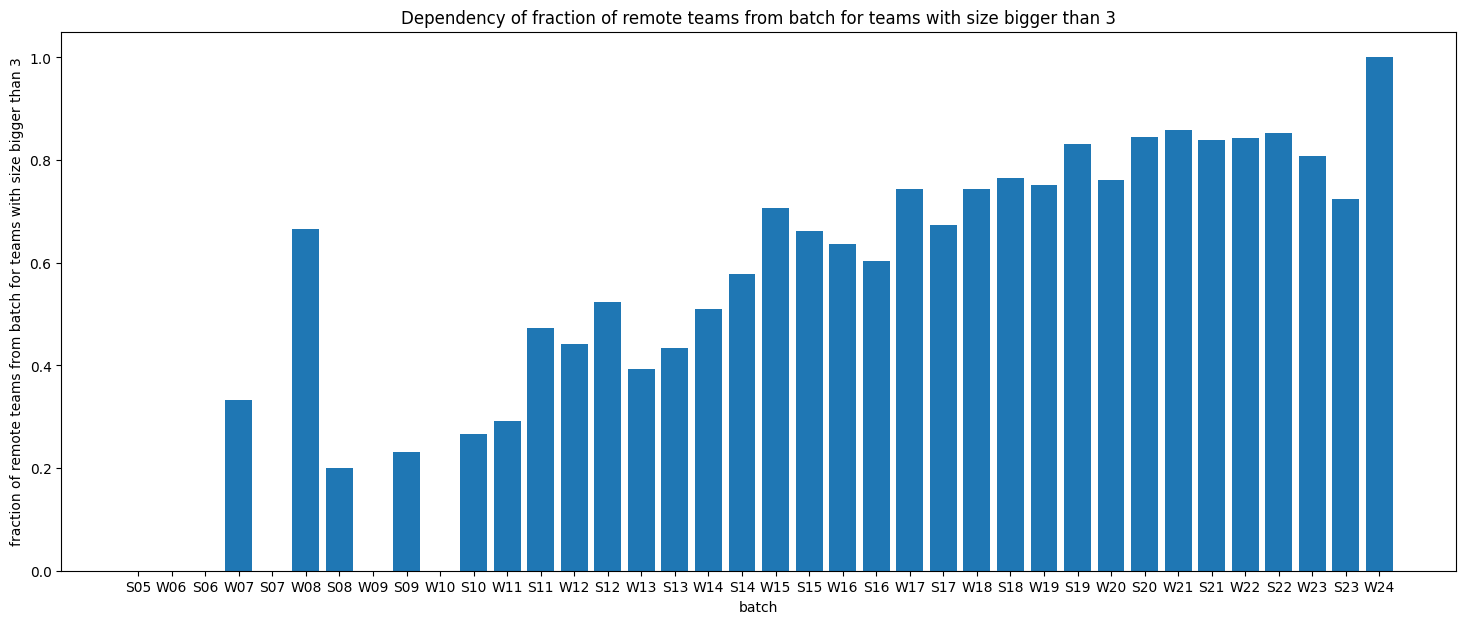

In [325]:
plt.figure(figsize=(18, 7))

plt.bar([batch[0] for batch in sorted_all_batches], [batch[1] for batch in sorted_all_batches])

plt.title('Dependency of fraction of remote teams from batch for teams with size bigger than 3')
plt.xlabel('batch')
plt.ylabel('fraction of remote teams from batch for teams with size bigger than 3')


plt.show()

# Dependency of remote from team size

In [326]:
bins = [0, 3, 4, 7, 11, 26, 101, float('inf')]
labels = ['size <= 2', 'size = 3', 'size = (4-6)', 'size = (7-10)', 'size = (11-25)', 'size = (26-100)', 'size > 100']

data_pd_remote_size_batch['team_size_group'] = pd.cut(data_pd_remote_size_batch['team_size'], bins=bins, labels=labels, right=False)

# Group by the new column
data_pd_remote_size_batch['remote_fraction'] = data_pd_remote_size_batch.groupby('team_size_group').has_remote.transform(np.mean)

pd_group_remote_fraction = data_pd_remote_size_batch[['team_size_group', 'remote_fraction']].drop_duplicates()
dict_group_remote_fraction = pd_group_remote_fraction.set_index('team_size_group')['remote_fraction'].to_dict()
del dict_group_remote_fraction[np.nan]

sorted_all_groups = sorted(dict_group_remote_fraction.items(), key=lambda group: labels.index(group[0]))

<ipython-input-326-ed4d16b952a6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd_remote_size_batch['team_size_group'] = pd.cut(data_pd_remote_size_batch['team_size'], bins=bins, labels=labels, right=False)
<ipython-input-326-ed4d16b952a6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd_remote_size_batch['remote_fraction'] = data_pd_remote_size_batch.groupby('team_size_group').has_remote.transform(np.mean)


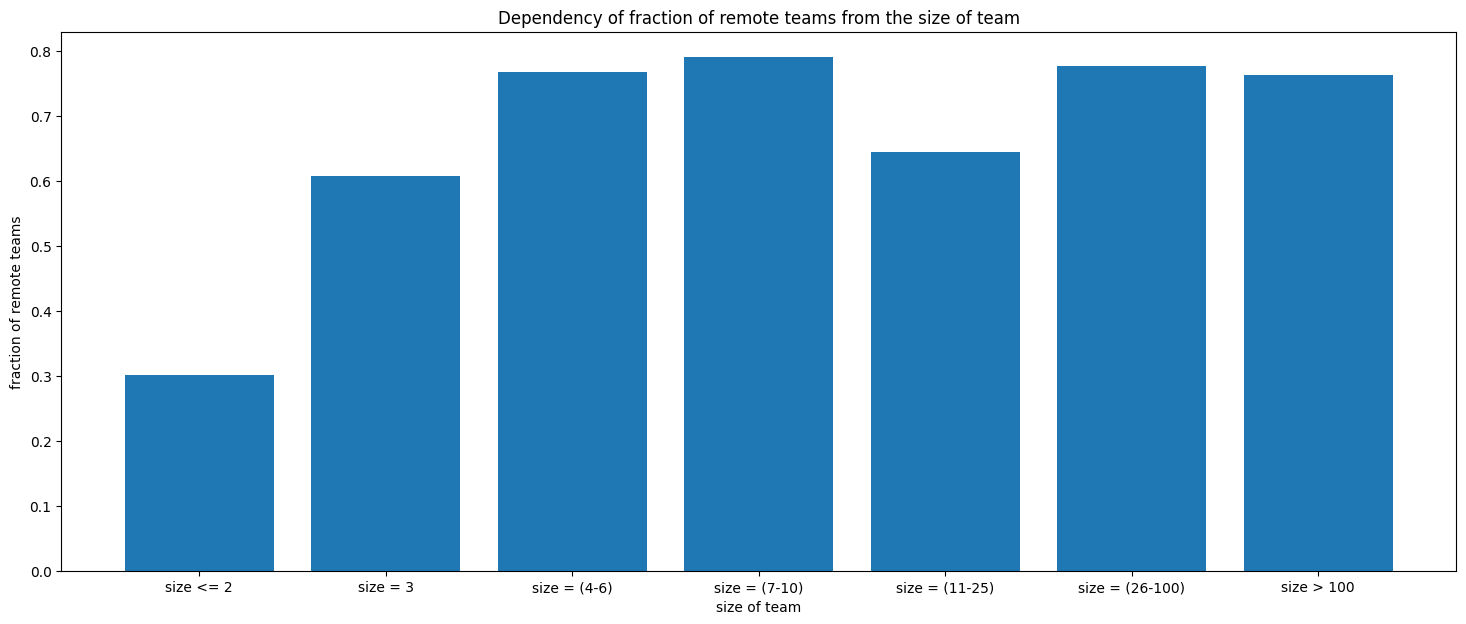

In [327]:
plt.figure(figsize=(18, 7))

plt.bar([group[0] for group in sorted_all_groups], [group[1] for group in sorted_all_groups])

plt.title('Dependency of fraction of remote teams from the size of team')
plt.xlabel('size of team')
plt.ylabel('fraction of remote teams')


plt.show()

In [328]:
# Group by the new column
data_pd_remote_size_batch['remote_sum'] = data_pd_remote_size_batch.groupby('team_size_group').has_remote.transform(np.sum)

pd_group_remote_fraction = data_pd_remote_size_batch[['team_size_group', 'remote_sum']].drop_duplicates()
dict_group_remote_fraction = pd_group_remote_fraction.set_index('team_size_group')['remote_sum'].to_dict()
del dict_group_remote_fraction[np.nan]

sorted_all_groups = sorted(dict_group_remote_fraction.items(), key=lambda group: labels.index(group[0]))

<ipython-input-328-4d244f7d49f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd_remote_size_batch['remote_sum'] = data_pd_remote_size_batch.groupby('team_size_group').has_remote.transform(np.sum)


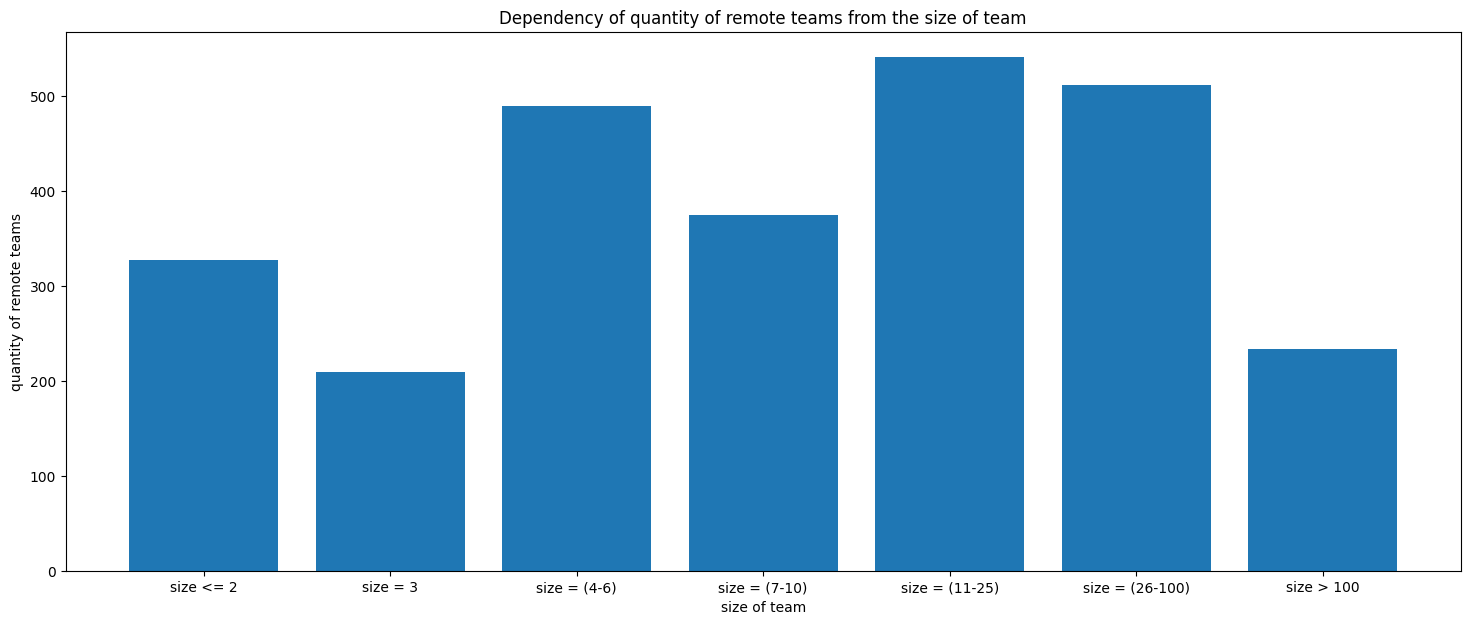

In [329]:
plt.figure(figsize=(18, 7))

plt.bar([group[0] for group in sorted_all_groups], [int(group[1]) for group in sorted_all_groups])

plt.title('Dependency of quantity of remote teams from the size of team')
plt.xlabel('size of team')
plt.ylabel('quantity of remote teams')


plt.show()

# Analysis of domen postfixes

In [330]:
data_pd_batch_more_3 = data_pd[data_pd['team_size'] > 3]

In [331]:
def get_website_postfix(website: str):
    parsed_url = urlparse(website)
    return parsed_url.netloc.split('.')[-1]


In [332]:
data_pd_remote = data_pd_batch_more_3[(data_pd_batch_more_3["all_locations"].apply(has_remote) == True)
                         | (data_pd_batch_more_3["regions"].apply(has_remote) == True)]

data_pd_remote = data_pd_remote.dropna(subset=['website'])
data_pd_remote['website_postfix'] = data_pd_remote['website'].apply(get_website_postfix)

In [333]:
counts_postfix_with_com = data_pd_remote['website_postfix'].value_counts()
print(counts_postfix_with_com)

com         1408
io           155
ai           123
co           111
app           39
            ... 
earth          1
exchange       1
ly             1
nyc            1
team           1
Name: website_postfix, Length: 105, dtype: int64


In [334]:
data_pd_remote_no_com = data_pd_remote[~data_pd_remote['website_postfix'].isin(['com'])]
counts_postfix = data_pd_remote_no_com['website_postfix'].value_counts()


In [335]:
sum_counts = np.sum(np.array(counts_postfix.values))
print("Perсent of domens with remote work for top-5 domens with remote work: ",
      np.sum(np.array(counts_postfix.values[:5])) / sum_counts * 100, "%")
print("Perсent of domens with remote work for top-10 domens with remote work: ",
      np.sum(np.array(counts_postfix.values[:10])) / sum_counts * 100, "%")
print("Perсent of domens with remote work for top-20 domens with remote work: ",
      np.sum(np.array(counts_postfix.values[:20])) / sum_counts * 100, "%")

Perсent of domens with remote work for top-5 domens with remote work:  61.943319838056674 %
Perсent of domens with remote work for top-10 domens with remote work:  73.8191632928475 %
Perсent of domens with remote work for top-20 domens with remote work:  83.94062078272604 %


In [336]:
def extract_top_values(counts_postfix):
    total_sum = np.sum(np.array(counts_postfix.values))
    threshold = 0.8 * total_sum
    selected_values = counts_postfix.cumsum() < threshold
    return counts_postfix[:np.sum(selected_values) + 1]

# Extract the subset of elements
result_subset = extract_top_values(counts_postfix)

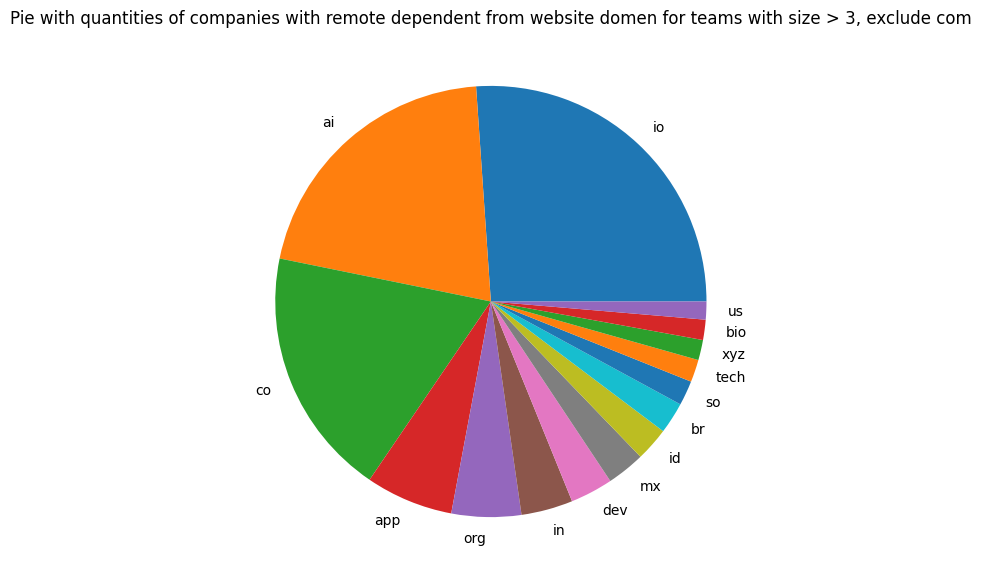

In [337]:
plt.figure(figsize=(7,7))


plt.pie(result_subset.values, labels=result_subset.index)
plt.title('Pie with quantities of companies with remote dependent from website domen for teams with size > 3, exclude com')

plt.show()

In [338]:
data_pd_with_website = data_pd_batch_more_3.dropna(subset=['website'])
data_pd_with_website['website_postfix'] = data_pd_with_website['website'].apply(get_website_postfix)
data_pd_postfix = data_pd_with_website['website_postfix'].value_counts()

<ipython-input-338-c544cab8e1bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pd_with_website['website_postfix'] = data_pd_with_website['website'].apply(get_website_postfix)


In [339]:
most_popular_postfixes = data_pd_postfix[:10].index

data_pd_with_website = data_pd_with_website[data_pd_with_website['website_postfix'].isin(most_popular_postfixes)]
top_10_most_popular_postfixes_all = data_pd_with_website['website_postfix'].value_counts()

data_pd_remote = data_pd_remote[data_pd_remote['website_postfix'].isin(most_popular_postfixes)]
top_10_most_popular_postfixes_remote = data_pd_remote['website_postfix'].value_counts()

In [340]:
top_10_fractions_website_postfix = [top_10_most_popular_postfixes_remote[i] / top_10_most_popular_postfixes_all[i]
                                    for i in range(len(top_10_most_popular_postfixes_all.values))]

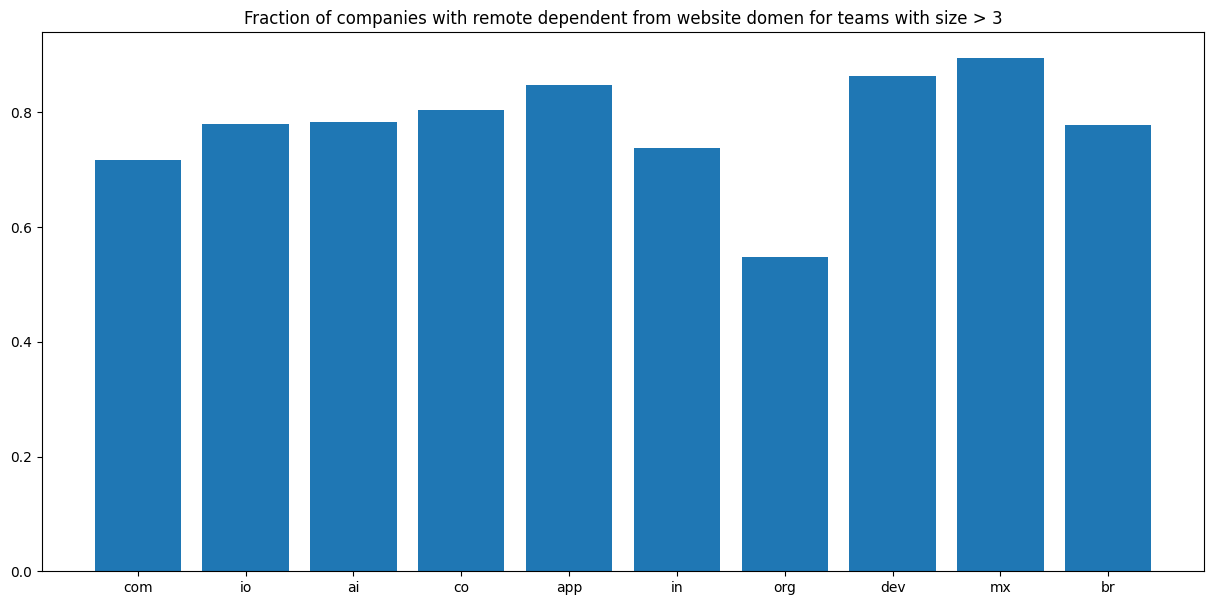

In [341]:
plt.figure(figsize=(15, 7))

plt.bar(most_popular_postfixes, top_10_fractions_website_postfix)
plt.title("Fraction of companies with remote dependent from website domen for teams with size > 3")

plt.show()

# Анализ удаленки в зависимости от региона

In [342]:
def get_locations(row, locations, locations_remote):
    if type(row['all_locations']) is float:
        return
    for location in row['all_locations'].split(';'):
        country = location.split(',')[-1].strip()
        if country == 'Remote':
            continue
        if country == 'USA':
            country = location.split(',')[-2].strip()
        locations[country] += 1
        if row['has_remote']:
            locations_remote[country] += 1

In [343]:
locations_num = defaultdict(int)
locations_remote_num = defaultdict(int)

data_pd_batch_more_3.apply(lambda row, locations=locations_num, locations_remote=locations_remote_num:
              get_locations(row, locations, locations_remote), axis=1)

0       None
2       None
3       None
7       None
10      None
        ... 
4408    None
4411    None
4413    None
4414    None
4416    None
Length: 2922, dtype: object

In [344]:
sorted_locations_num = sorted(locations_num.items(), key=lambda loc: loc[1], reverse=True)
sorted_locations_num_top_10 = sorted_locations_num[:10]

In [345]:
sorted_locations_remote_num = sorted(locations_remote_num.items(), key=lambda loc: loc[1], reverse=True)
sorted_locations_remote_num_top_10 = sorted_locations_remote_num[:10]

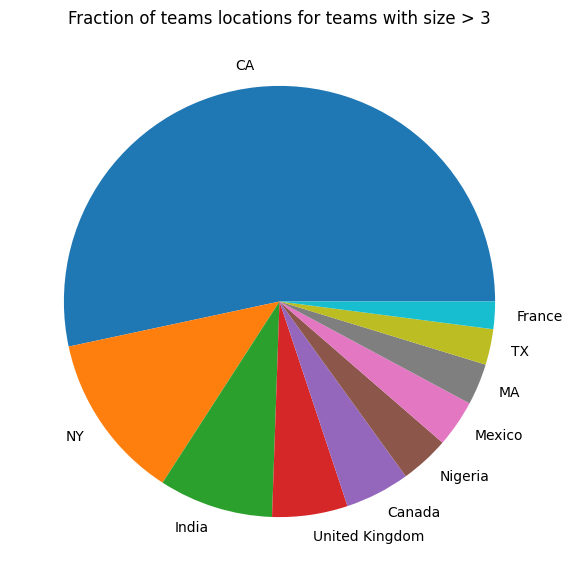

In [346]:
plt.figure(figsize=(7,7))


plt.pie([a[1] for a in sorted_locations_num_top_10],
        labels=[a[0] for a in sorted_locations_num_top_10])
plt.title('Fraction of teams locations for teams with size > 3')

plt.show()

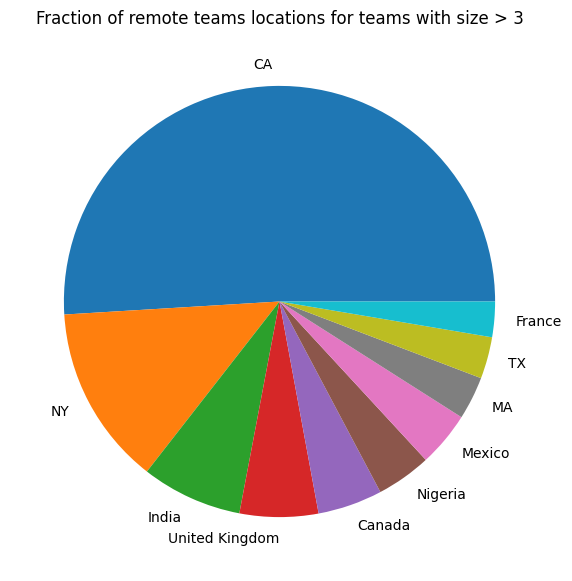

In [347]:
plt.figure(figsize=(7,7))


plt.pie([a[1] for a in sorted_locations_remote_num_top_10],
        labels=[a[0] for a in sorted_locations_remote_num_top_10])
plt.title('Fraction of remote teams locations for teams with size > 3')

plt.show()

In [348]:
locations_fraction = dict()

for location in locations_num.keys():
    locations_fraction[location] = locations_remote_num[location] / locations_num[location]

In [349]:
locations_num_sorted = sorted(locations_num.items(), key=lambda item: item[1], reverse=True)

top_10_locations = locations_num_sorted[:10]
top_10_locations_num_keys, _ = zip(*top_10_locations)

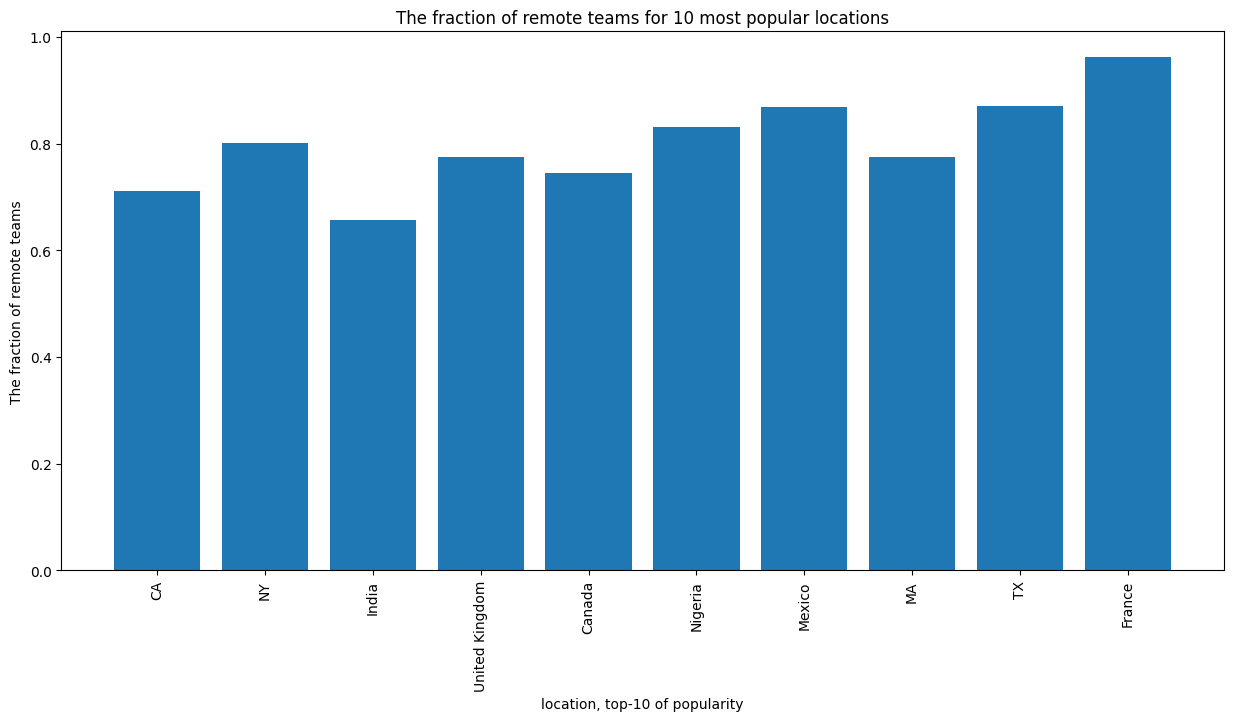

In [350]:
top_10_locations_fraction_values = [locations_fraction[key] for key in top_10_locations_num_keys]

plt.figure(figsize=(15, 7))

plt.bar(top_10_locations_num_keys, top_10_locations_fraction_values)
plt.title("The fraction of remote teams for 10 most popular locations")
plt.xticks(rotation='vertical')
plt.xlabel('location, top-10 of popularity')
plt.ylabel('The fraction of remote teams')

plt.show()

# Analysis of dependence of remote work from industry

In [351]:
industries_num = defaultdict(int)
industries_remote_num = defaultdict(int)


def get_industries(row, industries, industries_remote):
    indusries_list = ast.literal_eval(row['industries'])
    for industry in indusries_list:
        industries[industry] += 1
        if row['has_remote']:
            industries_remote[industry] += 1

data_pd_batch_more_3.apply(lambda row, industries=industries_num, industries_remote=industries_remote_num:
              get_industries(row, industries, industries_remote), axis=1)

industries_remote_num

defaultdict(int,
            {'B2B': 995,
             'Analytics': 52,
             'Industrials': 104,
             'Automotive': 9,
             'Supply Chain and Logistics': 67,
             'Engineering, Product and Design': 171,
             'Real Estate and Construction': 77,
             'Housing and Real Estate': 46,
             'Consumer': 249,
             'Consumer Electronics': 11,
             'Fintech': 364,
             'Consumer Finance': 41,
             'Operations': 55,
             'Banking and Exchange': 51,
             'Marketing': 48,
             'Climate': 25,
             'Retail': 53,
             'Travel, Leisure and Tourism': 12,
             'Asset Management': 22,
             'Unspecified': 9,
             'Productivity': 79,
             'Education': 87,
             'Sales': 47,
             'Infrastructure': 93,
             'Finance and Accounting': 49,
             'Healthcare': 253,
             'Healthcare IT': 42,
             'Recruiting and 

In [352]:
industries = list()
industries_remote_fraction = list()

for industry in industries_num.keys():
    industries.append(industry)
    industries_remote_fraction.append(industries_remote_num[industry] / industries_num[industry])

In [353]:
industries_fraction = dict()

for industry in industries_num.keys():
    industries_fraction[industry] = industries_remote_num[industry] / industries_num[industry]

In [354]:
industries_num_sorted = sorted(industries_num.items(), key=lambda item: item[1], reverse=True)

top_10_industries = industries_num_sorted[:10]
top_10_industries_num_keys, _ = zip(*top_10_industries)

bottom_10_industries = industries_num_sorted[-10:]
bottom_10_industries_num_keys, _ = zip(*bottom_10_industries)

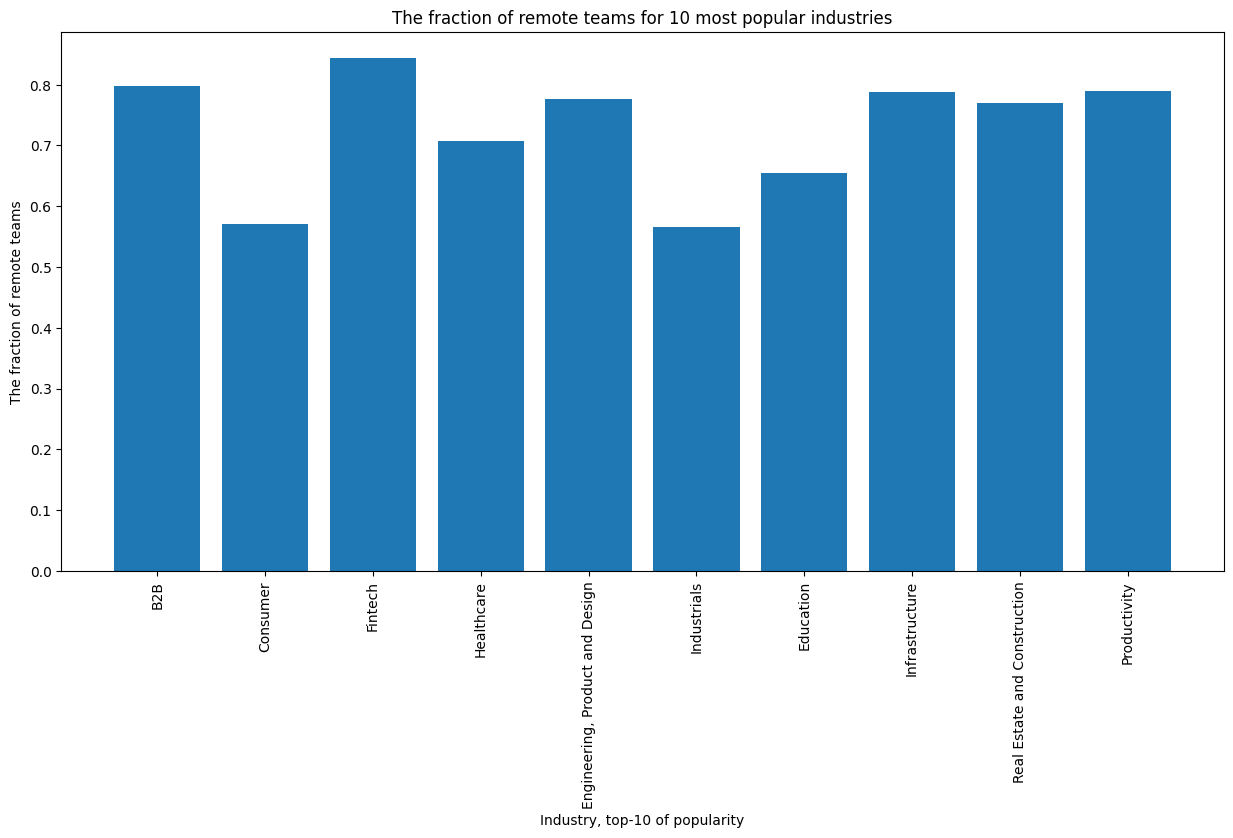

In [355]:
top_10_industries_fraction_values = [industries_fraction[key] for key in top_10_industries_num_keys]

plt.figure(figsize=(15, 7))

plt.bar(top_10_industries_num_keys, top_10_industries_fraction_values)
plt.title("The fraction of remote teams for 10 most popular industries")
plt.xticks(rotation='vertical')
plt.xlabel('Industry, top-10 of popularity')
plt.ylabel('The fraction of remote teams')

plt.show()

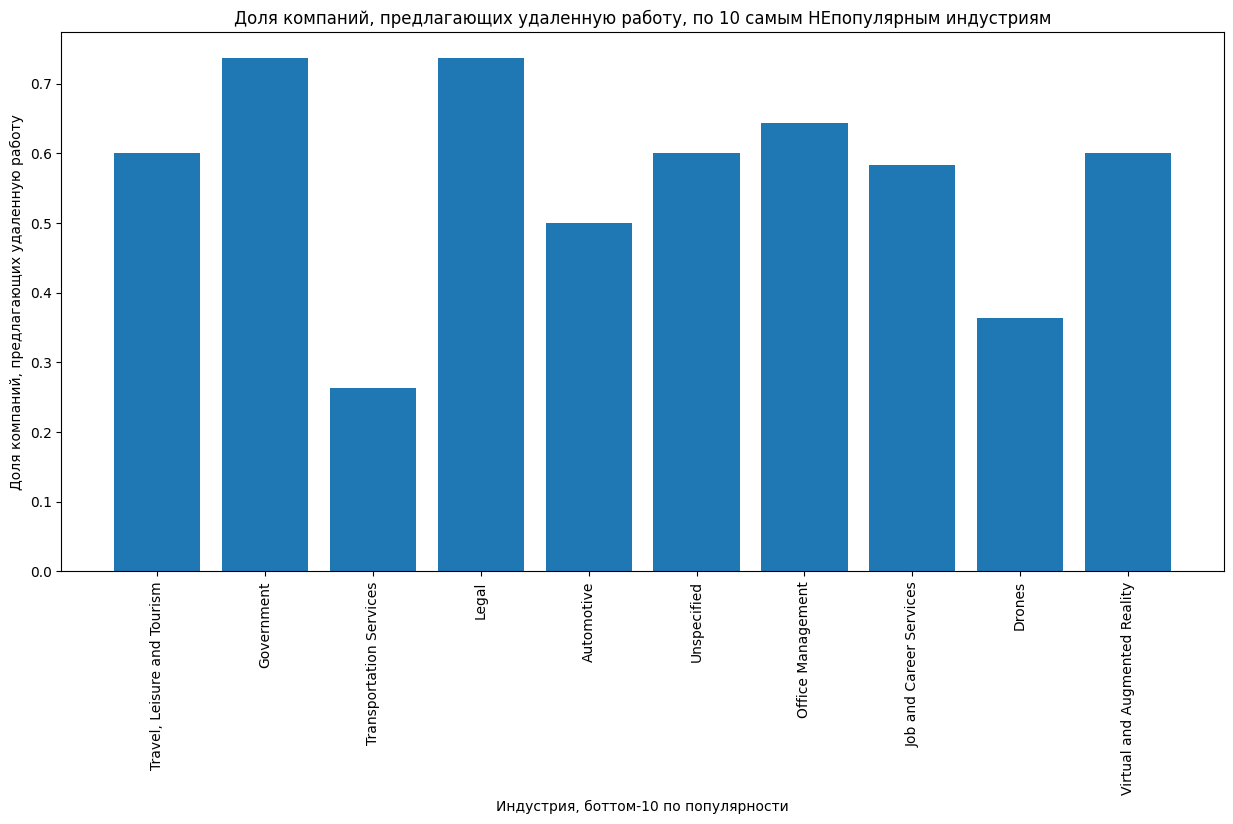

In [356]:
bottom_10_industries_fraction_values = [industries_fraction[key] for key in bottom_10_industries_num_keys]

plt.figure(figsize=(15, 7))

plt.bar(bottom_10_industries_num_keys, bottom_10_industries_fraction_values)
plt.title("Доля компаний, предлагающих удаленную работу, по 10 самым НЕпопулярным индустриям")
plt.xticks(rotation='vertical')
plt.xlabel('Индустрия, боттом-10 по популярности')
plt.ylabel('Доля компаний, предлагающих удаленную работу')

plt.show()

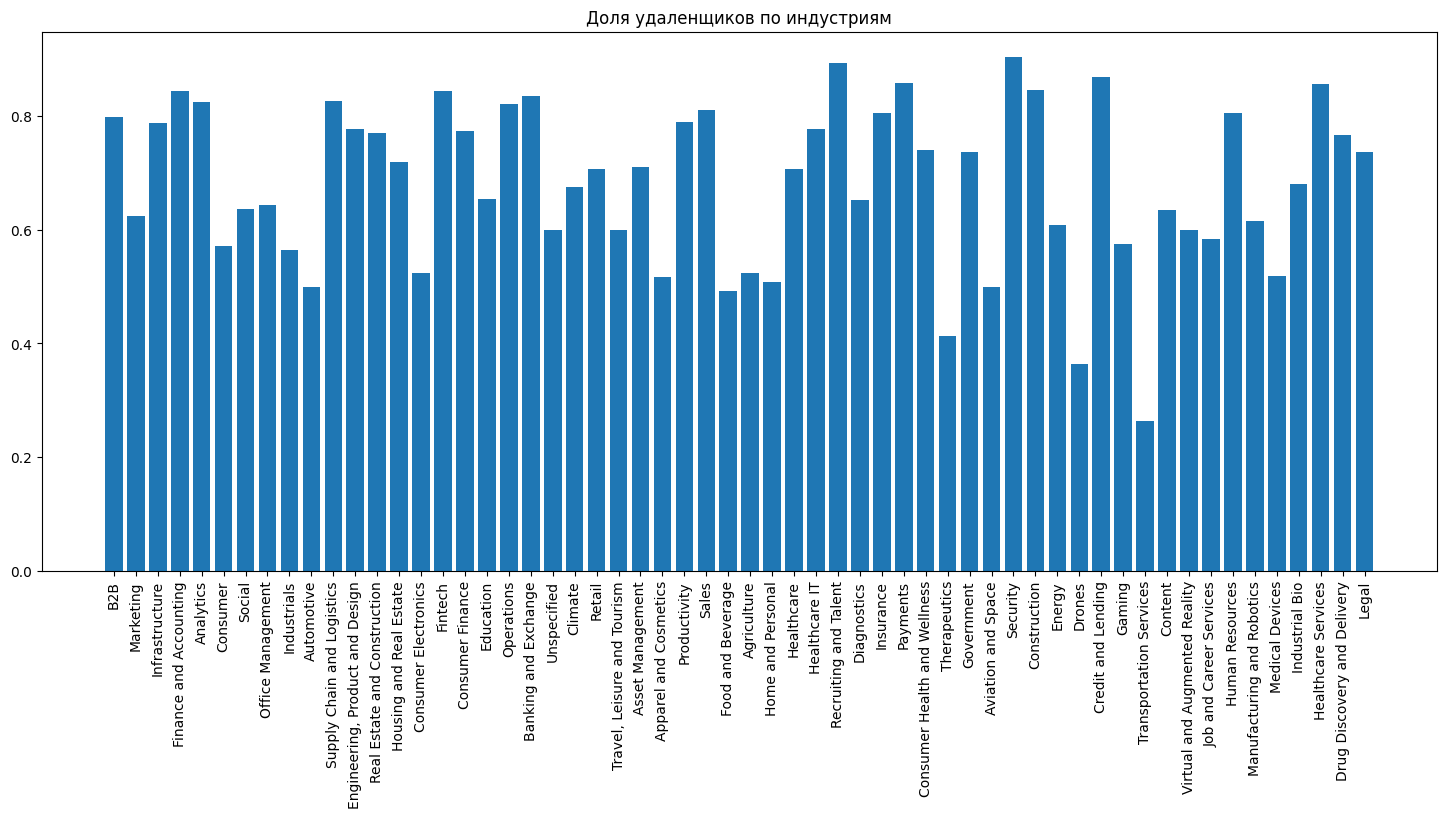

In [357]:
plt.figure(figsize=(18, 7))

plt.bar(industries, industries_remote_fraction)
plt.title("Доля удаленщиков по индустриям")
plt.xticks(rotation='vertical')

plt.show()

In [358]:
industries_fraction_sorted = sorted(industries_fraction.items(), key=lambda item: item[1], reverse=True)

print("10 индустрий с самой большой долей компаний с удаленной работой и доля:",
      [industry[0] for industry in industries_fraction_sorted][:10])

10 индустрий с самой большой долей компаний с удаленной работой и доля: ['Security', 'Recruiting and Talent', 'Credit and Lending', 'Payments', 'Healthcare Services', 'Construction', 'Finance and Accounting', 'Fintech', 'Banking and Exchange', 'Supply Chain and Logistics']


In [359]:
industries_fraction_sorted = sorted(industries_fraction.items(), key=lambda item: item[1])

print("10 индустрий с самой маленькой долей компаний с удаленной работой и доля:",
      [industry[0] for industry in industries_fraction_sorted][:10])

10 индустрий с самой маленькой долей компаний с удаленной работой и доля: ['Transportation Services', 'Drones', 'Therapeutics', 'Food and Beverage', 'Automotive', 'Aviation and Space', 'Home and Personal', 'Apparel and Cosmetics', 'Medical Devices', 'Consumer Electronics']


In [360]:
print(data_pd['has_remote'].mean())

0.6182929590219606


# All the same but for main industry

In [361]:
industries_num = defaultdict(int)
industries_remote_num = defaultdict(int)


def get_industries(row, industries, industries_remote):
    industry = row['industry']
    industries[industry] += 1
    if row['has_remote']:
        industries_remote[industry] += 1

data_pd_batch_more_3.apply(lambda row, industries=industries_num, industries_remote=industries_remote_num:
              get_industries(row, industries, industries_remote), axis=1)

industries_remote_num

defaultdict(int,
            {'B2B': 995,
             'Industrials': 104,
             'Real Estate and Construction': 77,
             'Consumer': 249,
             'Fintech': 364,
             'Unspecified': 9,
             'Education': 87,
             'Healthcare': 253,
             'Government': 14})

In [362]:
if 'Unspecified' in industries_num.keys():
    del industries_num['Unspecified']
if 'Unspecified' in industries_remote_num.keys():
    del industries_remote_num['Unspecified']

In [363]:
industries = list()
industries_remote_fraction = list()

for industry in industries_num.keys():
    industries.append(industry)
    industries_remote_fraction.append(industries_remote_num[industry] / industries_num[industry])

In [364]:
industries_fraction = dict()

for industry in industries_num.keys():
    industries_fraction[industry] = industries_remote_num[industry] / industries_num[industry]

In [365]:
industries_fraction_sorted = sorted(industries_fraction.items(), key=lambda item: item[1], reverse=True)

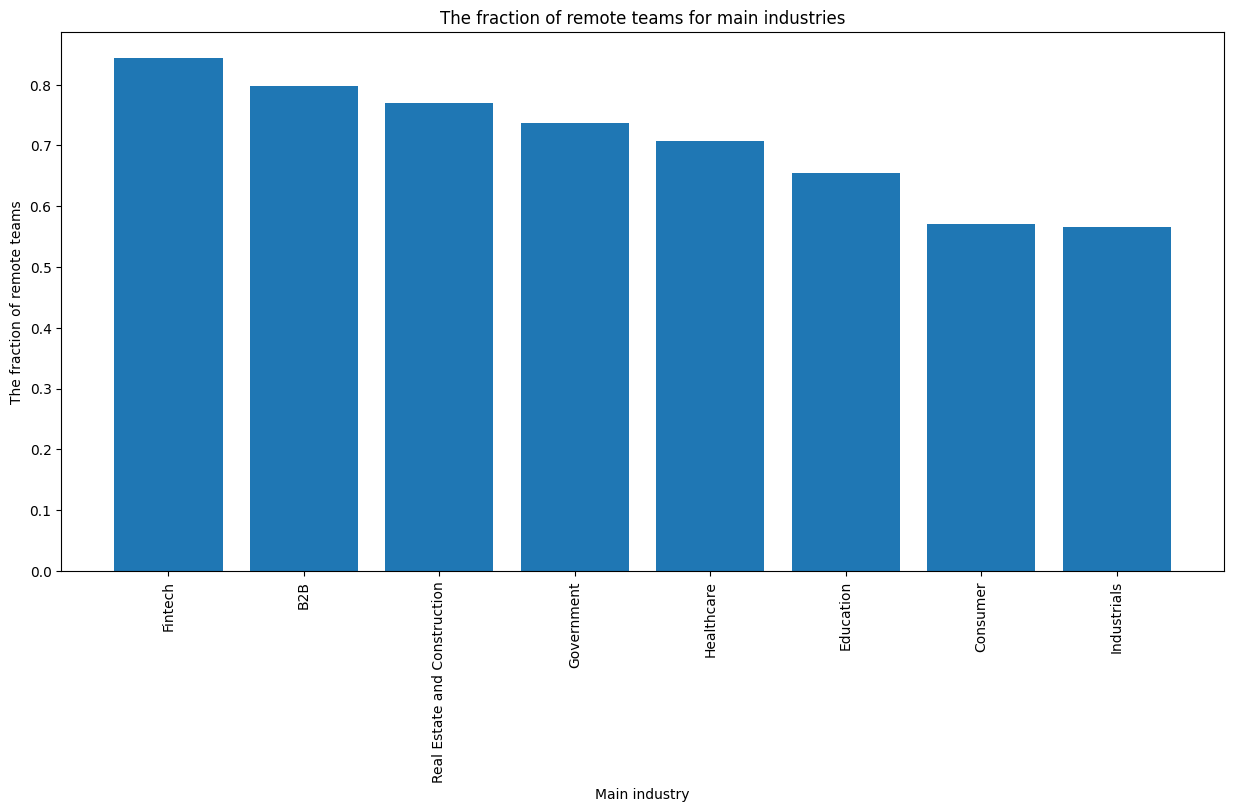

In [366]:
plt.figure(figsize=(15, 7))

plt.bar([industry[0] for industry in industries_fraction_sorted],
        [industry[1] for industry in industries_fraction_sorted])
plt.title("The fraction of remote teams for main industries")
plt.xticks(rotation='vertical')
plt.xlabel('Main industry')
plt.ylabel('The fraction of remote teams')

plt.show()

# Предсказание Remote по описанию проекта.

In [367]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [368]:
data_for_prediction = data_pd.reindex(columns=['long_description', 'has_remote'])
data_for_prediction = data_for_prediction.dropna(how="any")

data_for_prediction.head()

,long_description,has_remote
0,Wufoo is a web application that helps anybody ...,False
1,"Finding wedding vendors is hard. In 2007, a co...",False
2,Clustrix provides the leading scale-out relati...,False
3,"Inkling, based in Chicago, Illinois, offers co...",False
4,AudioBeta develops web-based applications that...,False


In [369]:
def preprocess_text(text):
    text = re.sub("\\\w", ' ', text)
    text = re.sub('[0-9]+', 'NUM', text)
    text = re.sub('[^a-zA-Z]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

In [370]:
data_for_prediction['long_description'] = data_for_prediction['long_description'].apply(preprocess_text)

In [371]:
from nltk.corpus import stopwords
from string import punctuation

noise = stopwords.words('english') + list(punctuation)

In [372]:
df_train = pd.DataFrame(columns=['text', 'label'])
df_val = pd.DataFrame(columns=['text', 'label'])
df_test = pd.DataFrame(columns=['text', 'label'])

df_train['text'], df_test['text'], df_train['label'], df_test['label'] =\
    train_test_split(data_for_prediction['long_description'], data_for_prediction['has_remote'], test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=1)

In [373]:
df_train

,text,label
3360,Tydo organizes complex data for DTC brands int...,True
4356,Snazzy is a direct to consumer teledentistry p...,True
3714,Anjuna makes hardware grade application and da...,True
1894,Casehopper is AI drafting tool for Immigration...,True
1707,Jumpcut creates captivating online courses Onl...,False
...,...,...
1690,The world s largest omnichannel communications...,False
1068,Fogbender helps BNUMB companies support custom...,True
738,Morf makes it easy to quickly setup and mainta...,True
132,LotusPay is the recurring payments solution fo...,False


In [374]:
train_texts = [[token.lower() for token in word_tokenize(text) if token.lower() not in noise] for text in df_train["text"].tolist()]
val_texts = [[token.lower() for token in word_tokenize(text) if token.lower() not in noise] for text in df_val["text"].tolist()]
test_texts = [[token.lower() for token in word_tokenize(text) if token.lower() not in noise] for text in df_test["text"].tolist()]

In [375]:
train_labels = df_train["label"].tolist()
val_labels = df_val["label"].tolist()
test_labels = df_test["label"].tolist()

In [376]:
class Vocabulary:
    def __init__(self):
        self.word2index = {
            "<pad>": 0,
            "<unk>": 1
        }
        self.index2word = ["<pad>", "<unk>"]

    def build(self, texts, min_count=1):
        words_counter = Counter(token for tokens in texts for token in tokens)
        for word, count in words_counter.most_common():
            if count >= min_count:
                self.word2index[word] = len(self.word2index)
        self.index2word = [word for word, _ in sorted(self.word2index.items(), key=lambda x: x[1])]

    def get_pad(self):
        return self.word2index["<pad>"]

    def get_unk(self):
        return self.word2index["<unk>"]

    @property
    def size(self):
        return len(self.index2word)

    def top(self, n=100):
        return self.index2word[1:n+1]

    def get_index(self, word):
        return self.word2index.get(word, self.get_unk())

    def get_word(self, index):
        return self.index2word[index]

vocabulary = Vocabulary()
vocabulary.build(train_texts)

In [377]:
class TextDataset(Dataset):
    def __init__(self, tokenized_texts, labels, vocabulary, max_seq_len=55):
        self.samples = []
        assert len(tokenized_texts) != 0
        assert len(tokenized_texts) == len(labels)
        for text, label in zip(tokenized_texts, labels):
            indices = [vocabulary.get_index(word) for word in text][:max_seq_len]
            indices += [vocabulary.get_pad() for _ in range(max_seq_len - len(indices))]
            self.samples.append((torch.LongTensor(indices), torch.LongTensor([label])))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        return self.samples[index]


BATCH_SIZE = 128

train_data = TextDataset(train_texts, train_labels, vocabulary)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)

val_data = TextDataset(val_texts, val_labels, vocabulary)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

test_data = TextDataset(test_texts, test_labels, vocabulary)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [378]:
class SimpleModel(LightningModule):
    def __init__(self):
        super().__init__()

        self.loss = nn.BCEWithLogitsLoss()
        self.valid_accuracy = Accuracy(task='binary')
        self.test_accuracy = Accuracy(task='binary')

    def forward(self, inputs, labels):
        raise NotImplementedError("forward not implemented")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return [optimizer]

    def training_step(self, batch, _):
        inputs, labels = batch
        loss, logits = self(inputs, labels)
        return loss

    def validation_step(self, batch, _):
        inputs, labels = batch
        val_loss, logits = self(inputs, labels)
        self.valid_accuracy.update(logits, labels)
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", self.valid_accuracy)

    def on_validation_epoch_end(self):
        self.log("val_acc_epoch", self.valid_accuracy.compute(), prog_bar=True)

    def test_step(self, batch, _):
        inputs, labels = batch
        test_loss, logits = self(inputs, labels)
        self.test_accuracy.update(logits, labels)
        self.log("test_loss", test_loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy)

    def on_test_epoch_end(self):
        self.log("test_acc_epoch", self.test_accuracy.compute(), prog_bar=True)

In [379]:
class RnnModel(SimpleModel):
    def __init__(self, vocab_size, embedding_dim=64):
        super().__init__()
        self.embeddings_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(embedding_dim, embedding_dim, batch_first=True, bidirectional=True)
        self.dropout_layer = nn.Dropout(0.2)
        self.out_layer = nn.Linear(2 * embedding_dim, 1)

    def forward(self, inputs, labels):
        batch_size = inputs.size(0)
        projections = self.embeddings_layer(inputs)
        # batch_size x seq_len x embedding_dim
        output, (final_hidden_state, final_cell_state) = self.lstm_layer(projections)
        # 2 x batch_size x embedding_dim
        final_hidden_state = final_hidden_state.transpose(0, 1)
        # batch_size x 2 x embedding_dim
        final_hidden_state = final_hidden_state.reshape(batch_size, -1)
        # batch_size x 2*embedding_dim
        hidden = self.dropout_layer(final_hidden_state)
        logits = self.out_layer(hidden)
        loss = self.loss(logits, labels.float())
        return loss, logits

rnn_model = RnnModel(vocabulary.size)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=1,
    verbose=True,
    mode="min"
)
trainer = Trainer(
    #checkpoint_callback=False,
    accumulate_grad_batches=1,
    max_epochs=10,
    #progress_bar_refresh_rate=10,
    callbacks=[early_stop_callback])
trainer.fit(rnn_model, train_loader, val_loader)
trainer.test(rnn_model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type              | Params
-------------------------------------------------------
0 | loss             | BCEWithLogitsLoss | 0     
1 | valid_accuracy   | BinaryAccuracy    | 0     
2 | test_accuracy    | BinaryAccuracy    | 0     
3 | embeddings_layer | Embedding         | 926 K 
4 | lstm_layer       | LSTM              | 66.6 K
5 | dropout_layer    | Dropout           | 0     
6 | out_layer        | Linear            | 129   
-------------------------------------------------------
993 K     Trainable params
0         Non-trainable params
993 K     Total params
3.972     Total estimated model params s

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.665


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.663


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.658


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.654


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.653


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 0.653. Signaling Trainer to stop.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6421568393707275     │
│      test_acc_epoch       │    0.6421568393707275     │
│         test_loss         │    0.7084388136863708     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7084388136863708,
  'test_acc': 0.6421568393707275,
  'test_acc_epoch': 0.6421568393707275}]

Выглядит так себе. Попробуем что-нибудь попроще.

In [380]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(df_train['text'])
X_test = count_vect.transform(df_test['text'])

In [381]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=10000).fit(X_train_counts, df_train['label'])
predicted = clf.predict(X_test)

In [382]:
from sklearn.metrics import *
acc = accuracy_score(predicted, df_test['label'])
micro_f1 = f1_score(predicted, df_test['label'], average = 'micro')
micro_p = precision_score(predicted, df_test['label'], average = 'micro')
micro_r = recall_score(predicted, df_test['label'], average = 'micro')
macro_f1 = f1_score(predicted, df_test['label'], average = 'macro')
macro_p = precision_score(predicted, df_test['label'], average = 'macro')
macro_r = recall_score(predicted, df_test['label'], average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.5956
micro F1=0.5956, micro P=0.5956, micro R=0.5956
macro F1=0.5522, macro P=0.5524, macro R=0.5572



Еще хуже.

# Средний размер команды среди компаний с удаленной работой и вообще

In [383]:
print(data_pd_remote["team_size"].describe())

count    1940.000000
mean       81.436598
std       349.230730
min         4.000000
25%         7.000000
50%        15.000000
75%        44.250000
max      7000.000000
Name: team_size, dtype: float64


In [384]:
print(data_pd['team_size'].describe())

count    4351.000000
mean       53.994024
std       317.598513
min         0.000000
25%         3.000000
50%         7.000000
75%        22.000000
max      8600.000000
Name: team_size, dtype: float64


In [385]:
print(data_pd_remote["team_size"].mean() - data_pd['team_size'].mean())

27.442573575928748


# Посмотрим на другой файл

In [386]:
deal_pd = pd.read_csv('YCombinator 2006-2023.csv')

deal_pd.head()

,xid,#,Companies,Company ID,Deal ID,Deal Date,Announced Date,Deal Size,Pre-money Valuation,Post Valuation,...,Lead/Sole Investors,Employees,Revenue Growth since last debt deal,Revenue,EBITDA,Total Debt (from financials),Deal Synopsis,Financing Status Note,CEO (at time of deal),CEO PBId
0,48635,48386,Parakey (Software Development Applications),52732-99,19117-54T,17/11/2006 00:00,NaN,1.56,13.27,14.83,...,NaN,NaN,NaN,NaN,NaN,NaN,The company raised $1.56 million of Series A f...,The company was acquired by Facebook (NASDAQ: ...,{'62492-86P': 'Blake Ross'},62492-86P
1,58836,58587,Snaptalent,61729-75,32010-85T,01/01/2008 00:00,NaN,2.00,4.03,6.03,...,NaN,NaN,NaN,NaN,NaN,NaN,The company joined Y Combinator as part of the...,The company is no longer actively in business ...,NaN,NaN
2,60141,59892,FriendFeed,41728-33,19653-94T,25/02/2008 00:00,NaN,5.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,The company raised $5 million of Series A vent...,The company was acquired by Facebook for $50 m...,{'167058-55P': 'Jim Norris'},167058-55P
3,64785,64536,RescueTime,52794-46,135800-20T,23/09/2008 00:00,NaN,0.90,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"The company raised $900,000 of seed funding fr...","True Ventures, Y Combinator, Lowercase Capital...",{'43621-03P': 'Brian Fioca'},43621-03P
4,66671,66422,CarWoo,51122-80,18676-81T,01/01/2009 00:00,NaN,1.93,2.69,4.62,...,NaN,NaN,NaN,NaN,NaN,NaN,The company raised $1.9 million of seed fundin...,The company is no longer actively in business ...,{'38143-27P': 'Robert McClung'},38143-27P


In [387]:
deal_pd.columns

Index(['xid', '#', 'Companies', 'Company ID', 'Deal ID', 'Deal Date',
       'Announced Date', 'Deal Size', 'Pre-money Valuation', 'Post Valuation',
       '% Acquired', 'Price per Share', 'Debt Raised in Round',
       'Raised to Date', 'Deal Class', 'Deal Type', 'Deal Size Status',
       'Post Valuation Status', 'Investors', 'New Investors',
       'Lead/Sole Investors', 'Employees',
       'Revenue Growth since last debt deal', 'Revenue', 'EBITDA',
       'Total Debt (from financials)', 'Deal Synopsis',
       'Financing Status Note', 'CEO (at time of deal)', 'CEO PBId'],
      dtype='object')

In [388]:
print(deal_pd.iloc[0])

xid                                                                                48635
#                                                                                  48386
Companies                                    Parakey (Software Development Applications)
Company ID                                                                      52732-99
Deal ID                                                                        19117-54T
Deal Date                                                               17/11/2006 00:00
Announced Date                                                                       NaN
Deal Size                                                                           1.56
Pre-money Valuation                                                                13.27
Post Valuation                                                                     14.83
% Acquired                                                                        0.1054
Price per Share      

In [389]:
print(deal_pd.shape)

(1347, 30)


In [390]:
merged_pd = pd.merge(data_pd_batch_more_3, deal_pd, left_on='name', right_on='Companies')

In [391]:
merged_pd.shape

(861, 63)

In [392]:
merged_pd[merged_pd['has_remote'] == True].shape

(681, 63)

In [393]:
merged_pd_true_remote = merged_pd[merged_pd['has_remote'] == True][merged_pd['Deal Size'].notna()]['Deal Size'].values
merged_pd_false_remote = merged_pd[merged_pd['has_remote'] == False][merged_pd['Deal Size'].notna()]['Deal Size'].values

<ipython-input-393-39cc9724d340>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  merged_pd_true_remote = merged_pd[merged_pd['has_remote'] == True][merged_pd['Deal Size'].notna()]['Deal Size'].values
<ipython-input-393-39cc9724d340>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  merged_pd_false_remote = merged_pd[merged_pd['has_remote'] == False][merged_pd['Deal Size'].notna()]['Deal Size'].values


In [394]:
merged_pd_all_remote = [merged_pd_true_remote, merged_pd_false_remote]

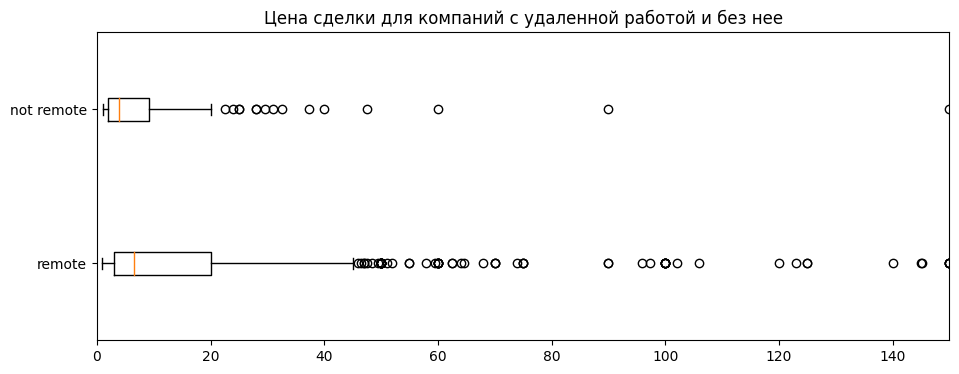

In [395]:
fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(111)

bp = ax.boxplot(merged_pd_all_remote, vert = 0)
ax.set_yticklabels(['remote', 'not remote'])

ax.set_title("Цена сделки для компаний с удаленной работой и без нее")
ax.set_xlim([0, 150])

plt.show()